In [7]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import scipy as sci
from scipy import constants
import pandas as pd
import csv
import math
from numpy import linspace, zeros

In [8]:
G = constants.G
c = constants.c
pi = constants.pi
print(pi, G, c)

3.141592653589793 6.6743e-11 299792458.0


In [9]:
#Read the text file of eos
eos_arr = np.loadtxt('eosaapr.txt', dtype = "str", delimiter = ',')
print("OK")
#Now, to convert this 1D arry of strings to 2D array of floats
#make the three arrays
P = np.zeros(len(eos_arr))
m = np.zeros(len(eos_arr))
e = np.zeros(len(eos_arr))
x = np.zeros(len(eos_arr))
for idx in range(len(eos_arr)):
    input_string = eos_arr[idx]
    str_values = input_string.split()
    float_values = [float(value) for value in str_values]
    #print(float_values)
    #eos_arr[i] = float_values
    P[idx], e[idx], x[idx] = float_values
    #print(P[idx], e[idx], x[idx])
print(len(eos_arr))

OK
172


In [10]:
#--converted to SI units MeV/fm^3 to Pa=J/m^2
factor = 1.60218e+32   
P = factor*P 
e = factor*e
# for idx in range(len(eos_arr)):
#     #print(P[idx], " ", e[idx], " ", x[idx])

In [11]:
def RK4_step(dy_dr, dz_dr, yi, zi, r, h, args):
    
    K1 = dy_dr(r, yi,  zi, args)
    L1 = dz_dr(r, yi , zi, args)
    #print("K1 and L1 done", K1, L1)
    #print(K1, L1)
    K2 = dy_dr(r + h/2, yi + h*K1/2, zi + h*L1/2, args)
    L2 = dz_dr(r + h/2, yi + h*K1/2, zi + h*L1/2, args)
    #print("K2 and L2 are done",K2, L2)
    #print("here is the der. ", dz_dr(r + h/2, yi + h*K1/2, zi + h*L1/2))
    K3 = dy_dr(r + h/2, yi + h*K2/2, zi + h*L2/2, args)
    L3 = dz_dr(r + h/2, yi + h*K2/2, zi + h*L2/2, args)
    #print("K3 and L3 are done", K3, L3)
    #print(dz_dr(r + h/2, yi + h*K2/2, zi + h*L2/2))
    K4 = dy_dr(r + h, yi + h*K3, zi + h*L3, args)
    L4 = dz_dr(r + h, yi + h*K3, zi + h*L3, args)
    #print("K4 and L4 are done", K4, L4)
    yi = yi + h*(K1 + 2*K2 + 2*K3 + K4)/6
    zi = zi + h*(L1 + 2*L2 + 2*L3 + L4)/6
    #print(yi, zi)
    return(yi, zi)

In [12]:
#Interpolation Code, for P 
# three arguments : P  and e are the arrays and temp is the value of density for which the pressure has to be found
def interpolate_P(temp, P, e):
    Pr = 0
    for idx in range(len(P)-1):
        #print(temp, " , ", e[idx])
        if (temp == e[idx]):
            Pr = P[idx]
            #print(Pr)
        elif(e[idx + 1] >= temp >= e[idx]):
            Pr = P[idx] + (temp-e[idx])*(P[idx + 1] - P[idx])/(e[idx + 1] - e[idx])
            #print(Pr)
#         else:
#             Pr = 0
#             print("Error, could not interpolate pressure")
#             break
    return Pr

def interpolate_e(temp, P, e):
    er = 0
    for idx in range(len(P)-1):
        #print(temp, " , ", P[idx])
        if (temp == P[idx]):
            er = e[idx]
            #print(er)
        elif(P[idx + 1] >= temp >= P[idx]):
            er = e[idx] + (temp-P[idx])*(e[idx + 1] - e[idx])/(P[idx + 1] - P[idx])
            #print(er)
#         else:
#             er = 0
#             print("Error, could not interpolate density")
#         break
    return er

In [13]:
#####################################
#define the derivative function to get dm/dr and dP/dr
def dm_dr(r, m_r, P_r, e_r):
    #e_r = interpolate_e(P_r, P, e)
    #print("inputs:", r, m_r, P_r, e_r)
    mprime = 4*pi*e_r*(r**2)/c**2
    #print("mprime:", mprime, "*********")
    return mprime

def dP_dr_nat(r, m_r, P_r, e_r):
    #e_r = interpolate_e(P_r, P, e)
    Pprime = -(e_r + P_r)*((m_r + 4*pi*(r**3)*P_r)/(r*r - 2*m_r*r))
    return Pprime

# def dP_dr_units(r, m_r, P_r):
#     e_r = interpolate_e(P_r, P, e)
#     Pprime = -(G/r*c**2)*(e_r + P_r)*((m_r*c**2 + 4*pi*r**3*P_r)/(r*c**2 - 2*G*m_r))
#     print("****", Pprime, "*********")
#     return Pprime

def dP_dr_units(r, m_r , P_r, e_r):
    #e_r = interpolate_e(P_r, P, e)
    #print("inputs:", r, m_r, P_r, e_r)
    Pprime = -(G*m_r/(r**2*c**2))*(e_r + P_r)*(1 + 4*pi*r**3*P_r/(m_r*c**2))*((1 - 2*G*m_r/(r*c**2))**(-1))
    #print("Pprime:", Pprime, "*********")
    return Pprime
#print(Pprime(ri, mi, pi))
######################################




In [14]:
#to produce the mass radius curve,
#write TOV_solver as a function of central density 
def TOV_solver(rc, rf , N , epsi , P , e):
    #first calculate the central sphere mass
    ri = rc
    m_c = (epsi/c**2)*4/3*pi*rc**3
    mi = m_c
    #input array 
    r = linspace(ri, rf, N)
    h = r[1] - r[0]
    #2d array for storing mass,pressure and energy density values
    y = np.zeros((3,N))
    #tov_solver code
    for i in range(N):
        #r[i] = r[i]*1000 #for SI units
        if(i == 0):
            y[0][i] = m[0] = mi
            y[1][i] = interpolate_P(epsi,P,e)
            y[2][i] = epsi
            #print(i, "  ",r[i], "  ", y[0][i], "  ", y[1][i], " ", y[2][i])
        else:
            if(y[1][i-1] >= 1e-20):
                y[2][i] = e_r = interpolate_e(y[1][i-1],P,e)
                y[0][i], y[1][i] = RK4_step(dm_dr,dP_dr_units, y[0][i-1],y[1][i-1],r[i],h, e_r)
                #print(i, "  ",r[i], "  ", y[0][i], "  ", y[1][i],"  ", y[2][i])
                if(y[1][i] == 0 or y[2][i] == 0):
                    print("error compensated")
            else:
                print(y[1][i-1], "Boundary reached")
                #print(i, "  ", r[i], "  ",  y[0][i], "  ", y[1][i], "  ", y[2][i])
                if(y[1][i] == 0 or y[2][i] == 0):
                    print("error compensated") 
                break
    M = y[0][i-1]/1.989e+30
    R = r[i-1]/1000
    print("mass:", M, " $M_{\odot}$ for radius:" , R , " km")
    return M,R

In [15]:
#define the array with central density values
epsi_l = 1e+32 #Si units
epsi_h = 1e+36
eps = linspace(epsi_l, epsi_h, 2000)

mass_R = np.zeros(len(eps))
radius_R = np.zeros(len(eps))

rc = 0.001
rf = 30000
N = 30000

for i in range(len(eps)):
    mass_R[i], radius_R[i] = TOV_solver(rc, rf , N , eps[i], P, e)


mass: 0.03189767460023317  $M_{\odot}$ for radius: 29.998999966698893  km
mass: 0.058853050913940406  $M_{\odot}$ for radius: 29.998999966698893  km
mass: 0.0696641286257475  $M_{\odot}$ for radius: 29.998999966698893  km
mass: 0.07494830989152958  $M_{\odot}$ for radius: 29.998999966698893  km
mass: 0.07795704957234319  $M_{\odot}$ for radius: 29.998999966698893  km
mass: 0.07977265980567719  $M_{\odot}$ for radius: 29.998999966698893  km
mass: 0.08095146264315177  $M_{\odot}$ for radius: 29.998999966698893  km
mass: 0.08171677503581222  $M_{\odot}$ for radius: 29.998999966698893  km
mass: 0.0822320868094507  $M_{\odot}$ for radius: 29.998999966698893  km
mass: 0.08256746763901443  $M_{\odot}$ for radius: 29.998999966698893  km
mass: 0.082833267015177  $M_{\odot}$ for radius: 29.998999966698893  km
mass: 0.08303907306070696  $M_{\odot}$ for radius: 29.998999966698893  km
mass: 0.08319405882066043  $M_{\odot}$ for radius: 29.998999966698893  km
mass: 0.08331127121620621  $M_{\odot}$ fo

In [16]:
np.savetxt( "mass_radius_APR_curve.txt", np.c_[eps, mass_R, radius_R])

In [17]:
#making a less dense array for the plot
mass_R_new = []
radius_R_new = []

for i in range(len(mass_R)):
    if(i % 3 == 0): 
        mass_R_new.append(mass_R[i])
        radius_R_new.append(radius_R[i])
        #print(i, " ", mass_R_new[i], "  ", radius_R_new[i])
print(len(mass_R_new))

667


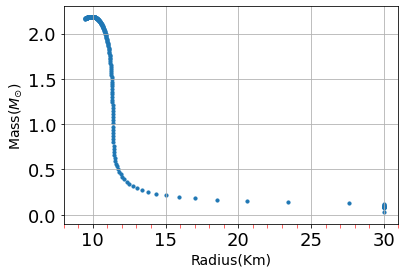

In [22]:
plt.scatter(radius_R_new, mass_R_new, s = 10)
plt.xlim(8,31)
plt.ylim(-0.1,2.3)
plt.xlabel("Radius(Km)", fontsize = '14')
plt.ylabel("Mass($M_{\odot}$)", fontsize = '14')
ax = plt.gca()  # Get the current axis
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='minor', length=4, color='r')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.show()